In [1]:
import pyaerocom as pya
import numpy as np
from collections import OrderedDict
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from pyaerocom.tstype import TsType
from pyaerocom.helpers import (make_datetime_index, to_pandas_timestamp)
from pyaerocom import const
import os
# %load_ext autoreload
# %autoreload 2

In [2]:
from pyaerocom.conftest import TEST_PATHS

In [3]:
testdatadir = (const._TESTDATADIR)
obs_path = os.path.join(testdatadir, TEST_PATHS['AeronetSunV3L2Subset.daily'])
obs_ref_path = os.path.join(testdatadir, TEST_PATHS['AeronetSDAV3L2Subset.daily'])

In [4]:
pya.const.add_ungridded_obs('AeronetSunV3', obs_path, reader=pya.io.ReadAeronetSunV3)
pya.const.add_ungridded_obs('AeronetSdaV3', obs_ref_path, reader=pya.io.ReadAeronetSdaV3)

In [6]:
r = pya.io.ReadUngridded('AeronetSunV3')
r_ref = pya.io.ReadUngridded('AeronetSdaV3')
obs = r.read(vars_to_retrieve='od550aer')
obs_ref = r_ref.read(vars_to_retrieve='od550aer')
var_ref = 'od550aer'
var = 'od550aer'

Reading AERONET data
100%|██████████| 22/22 [00:00<00:00, 36.19it/s]
Reading AERONET data
100%|██████████| 22/22 [00:00<00:00, 47.54it/s]


In [7]:
col_freq = 'hourly'
start = '2010-03-01'
stop = '2010-04-03'
start = to_pandas_timestamp(start)
stop = to_pandas_timestamp(stop)
dataset = obs.contains_datasets[0]
dataset_ref = obs_ref.contains_datasets[0]

In [13]:
tolerance = 1000

obs_ref_shortest = len(obs.station_name) > len(obs_ref.station_name)

if obs_ref_shortest:
    long = obs
    short = obs_ref
else:
    long = obs_ref
    short = obs

short_stats = short.to_station_data_all(start=start, stop=stop)['stats']
long_stats = long.to_station_data_all(start=start, stop=stop)['stats']
pd_freq = TsType(col_freq).to_pandas_freq()
time_idx = make_datetime_index(start, stop, pd_freq)
coldata = np.empty([2, len(time_idx), len(short_stats)])

lats = []; lons = [];
alts = []; station_names = [];
for i, short_stat in enumerate(short_stats):
    shortest_dist = tolerance + 1
    for long_stat in long_stats:
        dist = short_stat.dist_other(long_stat)
        if dist <= shortest_dist:
            if obs_ref_shortest:
                closest = {'obs': long_stat, 'obs_ref': short_stat}
            else:
                closest = {'obs': short_stat, 'obs_ref': long_stat}
            shortest_dist = dist
    obs_stat = closest['obs']
    obs_ref_stat = closest['obs_ref']
    obs_ts = obs_stat.resample_time(var, col_freq)[var]
    obs_ref_ts = obs_ref_stat.resample_time(var_ref, col_freq)[var_ref]
    obs_ts = obs_ts.reindex(index=time_idx)
    obs_ref_ts = obs_ref_ts.reindex(index=time_idx)
    _df = pd.concat([obs_ts, obs_ref_ts], axis=1, keys=['obs', 'obs_ref'])
    coldata[0, :, i] = _df['obs'].values
    coldata[1, :, i] = _df['obs_ref'].values
    lons.append(obs_stat.longitude)
    lats.append(obs_stat.latitude)
    alts.append(obs_stat.altitude)
    station_names.append(obs_stat.station_name)

In [14]:
from pyaerocom.helpers import to_datestring_YYYYMMDD
obs_ref_units = short_stat['var_info'][var_ref]['units']
obs_units = long_stat['var_info'][var]['units']
filter_name = ''
ts_type_src_ref = 'daily'
grid_ts_type_src = 'daily'
meta = {'data_source' : [dataset, dataset_ref],
            'var_name'          :   [var, var_ref],
            'var_units'         :   [obs_units, obs_ref_units],
            'ts_type'           :   col_freq, # will be updated below if resampling
            'filter_name'       :   filter_name,
            'ts_type_src'       :   [ts_type_src_ref, grid_ts_type_src],
            'start_str'         :   to_datestring_YYYYMMDD(start),
            'stop_str'          :   to_datestring_YYYYMMDD(stop)}
# meta.update(regfilter.to_dict())
coords = {'data_source' : meta['data_source'],
          'var_name'    : ('data_source', meta['var_name']),
          'var_units'   : ('data_source', meta['var_units']),
              'ts_type_src' : ('data_source', meta['ts_type_src']),
              'time'        : time_idx,
              'station_name': station_names,
              'latitude'    : ('station_name', lats),
              'longitude'   : ('station_name', lons),
              'altitude'    : ('station_name', alts)
              }

dims = ['data_source', 'time', 'station_name']
from pyaerocom import ColocatedData
data = ColocatedData(data=coldata, coords=coords, dims=dims, name=var,
                     attrs=meta)

In [15]:
data.data

<xarray.DataArray 'od550aer' (data_source: 2, time: 793, station_name: 10)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * data_source   (data_source) <U12 'AeronetSunV3' 'AeronetSdaV3'
    var_name      (data_source) <U8 'od550aer' 'od550aer'
    var_units     (data_source) <U1 '1' '1'
    ts_type_src   (data_source) <U5 'daily' 'daily'
  * time          (time) datetime64[ns] 2010-03-01 ... 2010-04-03
  * station_name  (station_name) <U16 'Alta_Floresta' ... 'Trelew'
    latitude      (station_name) float64 -9.871 -37.8 -37.8 ... 22.79 -43.25
    longitude     (station_name) float64 -56.1 77.57 77.57 ... 5.53 5.53 -65.31
    altitude      (station_name) float64 277.0 49.0 49.0 ... 1.377e+03 15.0
Attributes:
    data_source:  ['AeronetSunV3', 'AeronetSdaV3']
    var_name:     ['od550aer', 'od550aer']
    var_units:    ['1', '1']
    ts_type:      hourly
    filter_name:  
    ts_type_src:  ['daily', 'daily']
    start_str:    20100301
    stop_str:     20100403

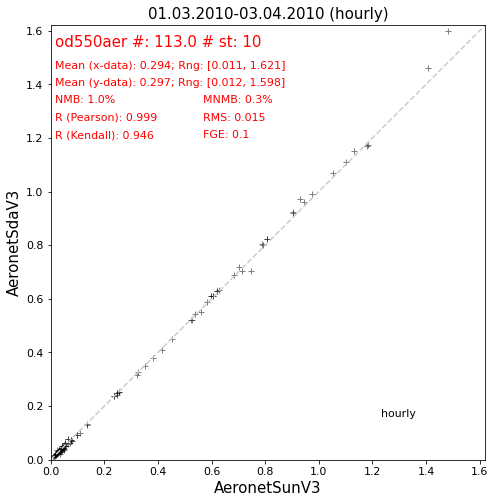

In [16]:
data.plot_scatter()